In [1]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.6 MB/s eta 0:00:00


In [2]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 6.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


def usable_ace(hand):
    """Verifica si un As puede usarse como 11 sin que la mano supere 21."""
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):
    """Calcula el total de la mano, considerando el valor del As."""
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


class BlackjackEnv(gym.Env):
    """
    Entorno personalizado de Blackjack basado en Gymnasium.

    Simula un entorno de Blackjack con reglas específicas y soporte
    para conteo de cartas utilizando el método Hi-Lo.
    """
    def __init__(self):
        super(BlackjackEnv, self).__init__()

        # Inicialización de variables de estado y parámetros del entorno
        self.true_count = 0             # Conteo verdadero basado en cartas vistas
        self.running_count = 0          # Conteo acumulado de cartas según Hi-Lo
        self.deck = []                  # Mazo de cartas
        self.step_count = 0             # Contador de pasos por ronda
        self.max_steps = 100            # Máximo de pasos por ronda
        self.round_over = False         # Estado de la ronda actual
        self.first_move = True          # Indica si es el primer movimiento de la ronda
        self.cut_card_position = None   # Posición de la carta de corte en el mazo
        self.cut_card_reached = False   # Estado de la carta de corte alcanzada
        self.log = []                   # Registro de eventos del entorno

        # Configuración de apuestas
        self.bet_levels = [10, 20, 30]          # Opciones de apuesta
        self.current_bet = self.bet_levels[0]   # Apuesta actual
        self.min_bet = self.bet_levels[0]       # Apuesta mínima
        self.max_bet = self.bet_levels[-1]      # Apuesta máxima
        self.next_bet = self.bet_levels[0]      # Apuesta para la próxima ronda

        # Espacios de acción y observación
        self.action_space = spaces.Discrete(3)  # Acciones: plantarse, pedir, doblar
        self.observation_space = spaces.Box(    # Espacio de observación: [suma del jugador, carta del dealer, true count, as jugable]
            low=np.array([0, 0, -10, 0]),
            high=np.array([32, 11, 10, 1]),
            dtype=np.float32,
        )

        # Barajar el mazo inicial
        self.shuffle_deck()

    def shuffle_deck(self):
        """Barajar el mazo y reiniciar el conteo."""
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 8 * 4
        np.random.shuffle(self.deck)

        # Establecer la posición de la carta de corte entre el 50% y el 65% del mazo
        deck_size = len(self.deck)
        self.cut_card_position = np.random.randint(int(deck_size * 0.5), int(deck_size * 0.65))
        self.log.append(f"[DEBUG] Posición de la carta de corte establecida: {self.cut_card_position}")
        self.cut_card_reached = False

        # Reiniciar conteo y log
        self.running_count = 0
        self.true_count = 0
        self.log = []
        self.log.append("[SHUFFLE] Mazo barajado, conteo reiniciado.")

    def draw_card(self):
        """Robar una carta del mazo y verificar la carta de corte."""
        card = self.deck.pop()

        # Verificar si alcanzamos la carta de corte
        if len(self.deck) <= self.cut_card_position and not self.cut_card_reached:
            self.cut_card_reached = True
            self.log.append(f"[CUT CARD] Se alcanzó la carta de corte en posición {len(self.deck)}.")

        # Actualizar el conteo de cartas
        self.update_running_count([card])

        self.log.append(f"[DRAW CARD] Carta robada: {card}")
        return card


    def reset(self, seed=None, options=None):
        """
        Reinicia el entorno para una nueva ronda.
        """
        if seed is not None:
            np.random.seed(seed)

        if self.cut_card_reached:
            self.log.append("[RESET] Barajando el mazo después de alcanzar la carta de corte.")
            self.shuffle_deck()
            self.cut_card_reached = False

        # Reinicia todos los parámetros de la ronda
        self.round_over = False
        self.step_count = 0
        self.first_move = True

        # Reparto inicial de cartas
        self.player_cards = [self.draw_card(), self.draw_card()]
        self.player_sum = sum_hand(self.player_cards)
        self.dealer_card = self.draw_card()
        self.dealer_cards = [self.dealer_card]

        self.player_blackjack = self._is_blackjack(self.player_cards)
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)
        self.current_bet = self.next_bet

        self.log.append(f"[RESET] Mano del jugador: {self.player_cards}, Carta del dealer: {self.dealer_card}")
        return self._get_obs(), {}

    def _is_blackjack(self, hand):
        """Determina si la mano tiene un Blackjack."""
        return len(hand) == 2 and sum_hand(hand) == 21

    def dealer_play(self):
        """Lógica para el turno del dealer."""
        # El dealer roba su carta 2 al inicio de su turno
        self.dealer_hidden_card = self.draw_card()
        self.dealer_cards.append(self.dealer_hidden_card)
        self.log.append(f"[DEALER] Carta 2 del dealer: {self.dealer_hidden_card}")
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)

        if not self._is_blackjack(self.dealer_cards) and not self._is_blackjack(self.player_cards):
            while sum_hand(self.dealer_cards) < 17:
                card = self.draw_card()
                self.dealer_cards.append(card)

        self.log.append(f"[DEALER] Cartas del dealer: {self.dealer_cards}")

    def step(self, action):
        """Realiza una acción del jugador."""
        reward = 0
        terminated = False
        truncated = False

        # Incrementar contador de pasos
        self.step_count += 1
        if self.step_count > self.max_steps:
            truncated = True
            reward = -self.current_bet
            return self._get_obs(), reward, terminated, truncated, {}

        # Evaluar si el jugador tiene Blackjack
        if self.player_blackjack:
            self.round_over = True
            self.log.append("[PLAYER] Blackjack detectado, paso al dealer.")
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Acciones del jugador
        if action == 0:  # Stand
            self.log.append("[ACTION] Stand")
            self.round_over = True
        elif action == 1:  # Hit
            self.log.append("[ACTION] Hit")
            card = self.draw_card()
            self.player_cards.append(card)
            self.player_sum = sum_hand(self.player_cards)
            self.first_move = False
            self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")

            # Si el jugador alcanza o supera 21, finaliza su turno
            if self.player_sum >= 21:
                self.log.append("[PLAYER] Mano alcanza o supera 21, turno finalizado.")
                self.round_over = True
        elif action == 2:  # Double
            self.log.append("[ACTION] Double")
            if self.first_move:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.current_bet = self.current_bet * 2
                self.first_move = False
                self.round_over = True
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}, Apuesta actual: {self.current_bet}")
            else:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.first_move = False
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")
                if self.player_sum >= 21:
                    self.round_over = True

        # Si el jugador se pasa, dealer gana automáticamente
        if self.player_sum > 21:
            self.log.append("[PLAYER] Mano se pasa de 21, dealer gana automáticamente.")
            reward = -self.current_bet
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Si la ronda ha terminado
        if self.round_over:
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True

        return self._get_obs(), reward, terminated, truncated, {}

    def adjust_bet(self):
        """Ajusta la apuesta para la próxima ronda según el true count."""
        if self.true_count < 1:
            self.next_bet = self.bet_levels[0]
        elif 1 <= self.true_count < 3:
            self.next_bet = self.bet_levels[1]
        else: # self.true_count > 3:
            self.next_bet = self.bet_levels[2]
        self.log.append(f"[ADJUST BET] Nueva apuesta establecida: {self.next_bet}")

    def update_running_count(self, cards):
        """Actualizar el conteo de cartas vistas."""
        hilo_values = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 1: -1}
        for card in cards:
            self.running_count += hilo_values.get(card, 0)

    def calculate_true_count(self):
        """Calcular el true count basado en el conteo actual y el mazo restante según el método Hi-Lo."""
        remaining_decks = len(self.deck) / 52
        if remaining_decks > 0:
            self.true_count = self.running_count / (remaining_decks * 2)
        else:
            self.true_count = 0
        self.log.append(f"[TRUE COUNT] Remaining decks: {remaining_decks}, Running count: {self.running_count}, True count: {self.true_count}")


    def _get_obs(self):
        """Devuelve la observación actual."""
        has_usable_ace = 1 if usable_ace(self.player_cards) else 0
        return np.array([self.player_sum, self.dealer_card, self.true_count, has_usable_ace], dtype=np.float32)

    def _calculate_reward(self):
        """Calcula el resultado de la ronda."""
        # Recompensas específicas para Blackjack
        if self.player_blackjack:
            if self.dealer_blackjack:
                return 0  # Empate
            else:
                return self.current_bet * 1.5  # Ganancia por Blackjack
        elif self.dealer_blackjack:
            return -self.current_bet  # Dealer gana con Blackjack

        # Recompensas estándar
        if self.player_sum > 21:
            return -self.current_bet
        elif sum_hand(self.dealer_cards) > 21 or self.player_sum > sum_hand(self.dealer_cards):
            return self.current_bet
        elif self.player_sum < sum_hand(self.dealer_cards):
            return -self.current_bet
        return 0


In [5]:
env = BlackjackEnv()
for _ in range(300):  # Robar muchas cartas
    card = env.draw_card()
    if env.cut_card_reached:
        print(f"Carta de corte alcanzada en posición {len(env.deck)}")
        break

Carta de corte alcanzada en posición 208


In [6]:

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


def usable_ace(player_cards):
    """
    Devuelve True si el jugador tiene un As usable (As que puede contar como 11 sin pasarse de 21).
    """
    return 1 in player_cards and sum(player_cards) + 10 <= 21


def basic_strategy(player_sum, dealer_card, has_usable_ace):
    """
    Implementa la estrategia básica de Blackjack basada en tablas.
    Acciones:
    0: Stand, 1: Hit, 2: Double
    """
    # Tabla de decisiones para Hard Totals (manos sin As usable)
    hard_totals = {
        4: [1] * 10, 5: [1] * 10, 6: [1] * 10, 7: [1] * 10, 8: [1] * 10,
        9: [1, 2, 2, 2, 2, 1, 1, 1, 1, 1],
        10: [2, 2, 2, 2, 2, 2, 2, 2, 1, 1],
        11: [2, 2, 2, 2, 2, 2, 2, 2, 1, 1],
        12: [1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        13: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        14: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        15: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        16: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        17: [0] * 10,
        18: [0] * 10,
        19: [0] * 10,
        20: [0] * 10,
    }

    # Tabla de decisiones para Soft Totals (manos con As usable)
    soft_totals = {
        13: [1, 1, 1, 2, 2, 1, 1, 1, 1, 1],
        14: [1, 1, 1, 2, 2, 1, 1, 1, 1, 1],
        15: [1, 1, 2, 2, 2, 1, 1, 1, 1, 1],
        16: [1, 1, 2, 2, 2, 1, 1, 1, 1, 1],
        17: [1, 2, 2, 2, 2, 1, 1, 1, 1, 1],
        18: [0, 2, 2, 2, 2, 0, 0, 1, 1, 1],
        19: [0] * 10,
        20: [0] * 10,
    }

    # Determinar si la mano es "hard" o "soft"
    dealer_card = int(dealer_card)  # Asegura que sea un índice válido
    if has_usable_ace:
        if player_sum in soft_totals:
            return soft_totals[player_sum][dealer_card - 2]
    else:
        if player_sum in hard_totals:
            return hard_totals[player_sum][dealer_card - 2]

    # Acción por defecto (Stand)
    return 0


def test_basic_strategy(env, num_episodes=1000):
    """
    Simula varios episodios en el entorno de Blackjack usando la estrategia básica,
    recopilando estadísticas y generando gráficos al final.
    """
    total_reward = 0
    wins, losses, draws = 0, 0, 0
    bust_count = 0  # Veces que el jugador se pasa de 21
    actions_count = Counter({"Stand": 0, "Hit": 0, "Double": 0})
    rewards_per_episode = []

    for episode in range(num_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Extraer valores de la observación
            player_sum, dealer_card, true_count, has_usable_ace = obs

            # Decide la acción usando la estrategia básica
            action = basic_strategy(player_sum, dealer_card, has_usable_ace)
            actions_count[["Stand", "Hit", "Double"][action]] += 1

            # Realiza la acción en el entorno
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward

            # Verifica si el jugador se pasa de 21
            player_sum = obs[0]  # Actualizar la suma del jugador
            if player_sum > 21:
                bust_count += 1

        # Actualiza las estadísticas
        total_reward += episode_reward
        rewards_per_episode.append(episode_reward)

        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    # Resumen final
    print("\n--- Resumen de Resultados ---")
    print(f"Victorias: {wins}")
    print(f"Derrotas: {losses}")
    print(f"Empates: {draws}")
    print(f"Recompensa Total: {total_reward:.2f}")
    print(f"Recompensa Promedio: {total_reward / num_episodes:.2f}")
    print(f"Plantarse: {actions_count['Stand']}")
    print(f"Pedir: {actions_count['Hit']}")
    print(f"Doblar: {actions_count['Double']}")
    print(f"Pasarse de 21: {bust_count}")

    # Generar gráficos
    labels = ['Victorias', 'Derrotas', 'Empates']
    results = [wins, losses, draws]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(labels, results, color=['green', 'red', 'blue'])
    plt.title('Resultados de los Episodios')
    plt.xlabel('Resultados')
    plt.ylabel('Cantidad')

    action_labels = ['Stand', 'Hit', 'Double']
    action_values = [actions_count['Stand'], actions_count['Hit'], actions_count['Double']]

    plt.subplot(1, 2, 2)
    plt.bar(action_labels, action_values, color=['orange', 'purple', 'cyan'])
    plt.title('Distribución de Acciones Tomadas')
    plt.xlabel('Acciones')
    plt.ylabel('Cantidad')

    plt.tight_layout()
    plt.show()



--- Resumen de Resultados ---
Victorias: 43100
Derrotas: 48270
Empates: 8630
Recompensa Total: -13075.00
Recompensa Promedio: -0.13
Plantarse: 69730
Pedir: 61475
Doblar: 9440
Pasarse de 21: 17756


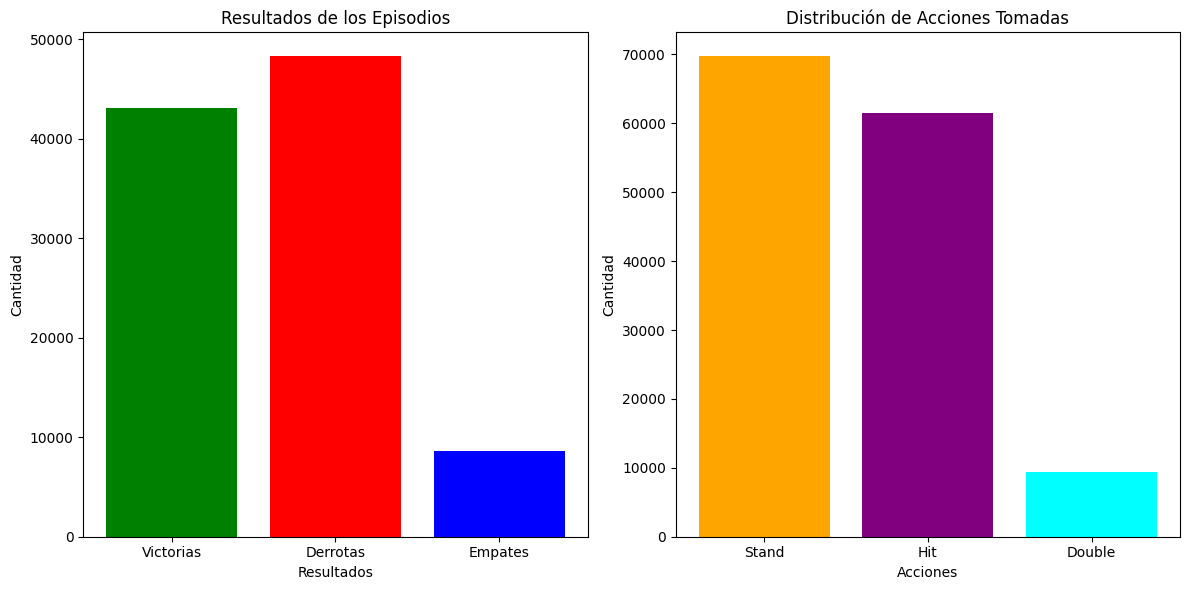

In [33]:
# Instanciar el entorno y probar la estrategia básica
env = BlackjackEnv()  # Asegúrate de tener tu entorno definido.
test_basic_strategy(env, num_episodes=100000)

In [26]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [27]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import DQN
import optuna

# Definir función de optimización
def optimize_dqn(trial):
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3)
    buffer_size = trial.suggest_categorical("buffer_size", [10_000, 50_000, 100_000])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    gamma = trial.suggest_float("gamma", 0.8, 0.999)
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.3)
    exploration_final_eps = trial.suggest_float("exploration_final_eps", 0.01, 0.1)

    env = BlackjackEnv()
    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        batch_size=batch_size,
        gamma=gamma,
        exploration_fraction=exploration_fraction,
        exploration_final_eps=exploration_final_eps,
        verbose=0,
    )

    model.learn(total_timesteps=50_000)

    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
    return mean_reward

# Ejecutar optimización
study = optuna.create_study(direction="maximize")
study.optimize(optimize_dqn, n_trials=50)

print("Mejores hiperparámetros:", study.best_params)

[I 2025-01-25 11:28:18,919] A new study created in memory with name: no-name-ac9b6161-0f64-4ec9-a1e0-c4c0d206ebb5
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2025-01-25 11:29:26,496] Trial 0 finished with value: 2.5 and parameters: {'learning_rate': 0.0005370735325143289, 'buffer_size': 50000, 'batch_size': 32, 'gamma': 0.8629970170014242, 'exploration_fraction': 0.2692519826092778, 'exploration_final_eps': 0.05442362535056143}. Best is trial 0 with value: 2.5.
[I 2025-01-25 11:30:28,159] Trial 1 finished with value: -4.0 and parameters: {'learning_rate': 1.1123523743899384e-05, 'buffer_size': 50000, 'batch_size': 128, 'gamma': 0.8388078791591674, 'exploration_fraction': 0.158264718

Mejores hiperparámetros: {'learning_rate': 0.0009413011581942735, 'buffer_size': 10000, 'batch_size': 32, 'gamma': 0.8148341210760645, 'exploration_fraction': 0.1839411161279116, 'exploration_final_eps': 0.05942409584184802}


In [28]:
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DQN

# Mejores hiperparámetros: {'learning_rate': 0.0007168336619036415, 'buffer_size': 50000, 'batch_size': 32, 'gamma': 0.8469397782860346, 'exploration_fraction': 0.14989674640355097, 'exploration_final_eps': 0.06331903302961385}
# Mejores hiperparámetros: {'learning_rate': 0.0009413011581942735, 'buffer_size': 10000, 'batch_size': 32, 'gamma': 0.8148341210760645, 'exploration_fraction': 0.1839411161279116, 'exploration_final_eps': 0.05942409584184802}




# Definir el entorno
env = BlackjackEnv()

# Configurar el entorno como vectorizado
vec_env = make_vec_env(lambda: env, n_envs=1)

# Callbacks para evaluar y guardar el modelo durante el entrenamiento
eval_callback = EvalCallback(
    vec_env,
    best_model_save_path='./best_model/',
    log_path='./logs/',
    eval_freq=10000,  # Frecuencia de evaluación
    n_eval_episodes=10,  # Número de episodios de evaluación
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=5000,  # Frecuencia de guardado
    save_path='./checkpoints/',
    name_prefix='dqn_blackjack'
)

# Configurar los hiperparámetros óptimos
model = DQN(
    "MlpPolicy",                                # Política con redes neuronales MLP
    vec_env,                                    # Entorno vectorizado
    learning_rate=0.0009413011581942735,        # Tasa de aprendizaje óptima
    buffer_size=10000,                          # Tamaño del buffer de experiencia
    batch_size=32,                              # Tamaño de lote
    gamma=0.8148341210760645,                   # Factor de descuento
    exploration_fraction=0.1839411161279116,    # Fracción del entrenamiento con exploración alta
    exploration_final_eps=0.05942409584184802,  # Épsilon mínimo para epsilon-greedy
    train_freq=4,                               # Frecuencia de entrenamiento (cada 4 pasos)
    target_update_interval=10000,               # Frecuencia de actualización de la red objetivo
    learning_starts=1000,                       # Pasos antes de comenzar a entrenar
    verbose=1,                                  # Nivel de verbosidad
    tensorboard_log="./tensorboard_logs/"       # Ruta para los logs de TensorBoard
)

# Entrenar el modelo
model.learn(
    total_timesteps=500000,                       # Número total de pasos de entrenamiento
    callback=[eval_callback, checkpoint_callback] # Callbacks para evaluación y guardado
)

# Guardar el modelo final
model.save("dqn_blackjack")

print("Entrenamiento completado. El modelo final ha sido guardado.")

Se han truncado las últimas 5000 líneas del flujo de salida.
|    learning_rate    | 0.000941 |
|    loss             | 3.83     |
|    n_updates        | 124286   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.35     |
|    ep_rew_mean      | -0.5     |
|    exploration_rate | 0.0594   |
| time/               |          |
|    episodes         | 351960   |
|    fps              | 375      |
|    time_elapsed     | 1327     |
|    total_timesteps  | 498152   |
| train/              |          |
|    learning_rate    | 0.000941 |
|    loss             | 7.93     |
|    n_updates        | 124287   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.34     |
|    ep_rew_mean      | -0.85    |
|    exploration_rate | 0.0594   |
| time/               |          |
|    episodes         | 351964   |
|    fps              | 375  

In [29]:
# Descargar el modelo
from google.colab import files
files.download('dqn_blackjack.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import shutil
from google.colab import files

# Comprimir la carpeta de logs
shutil.make_archive("dqn_logs", "zip", "./logs")

# Descargar el archivo comprimido
files.download("dqn_logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

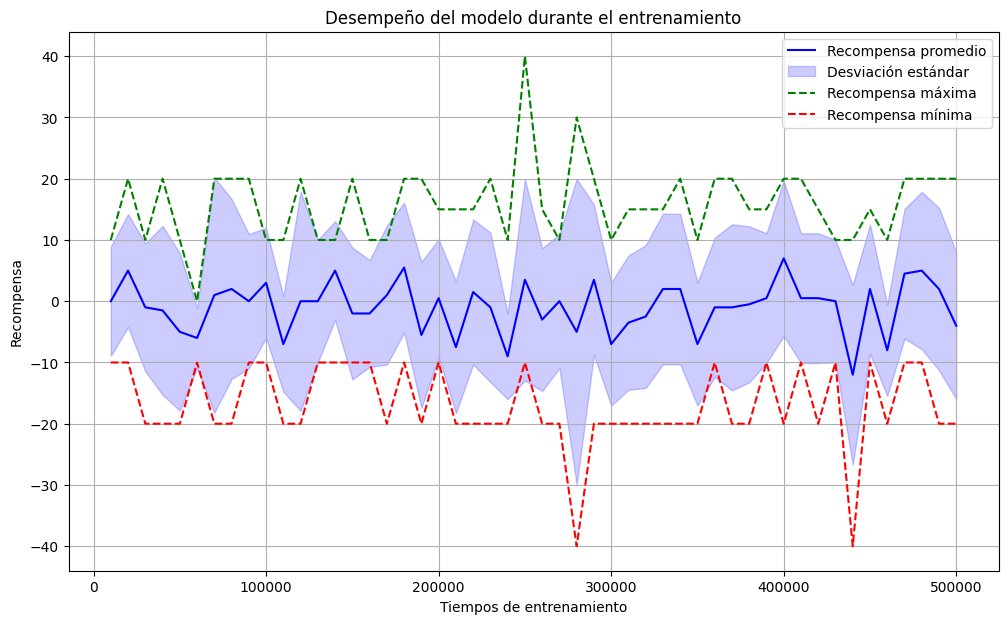

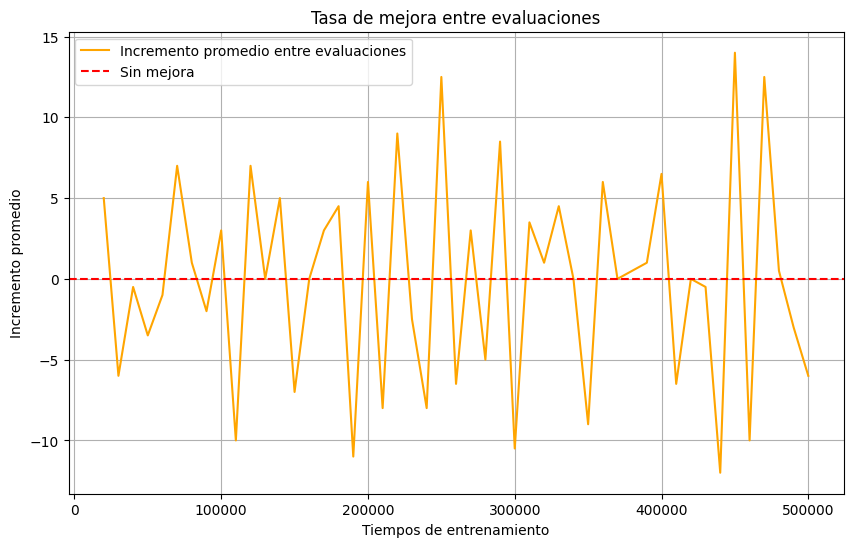

Estabilidad de las últimas recompensas (desviación estándar): 5.18
Porcentaje de evaluaciones con recompensa promedio > 0.8: 34.00%
El mejor modelo se obtuvo en el timestep 400000 con una recompensa promedio de 7.00


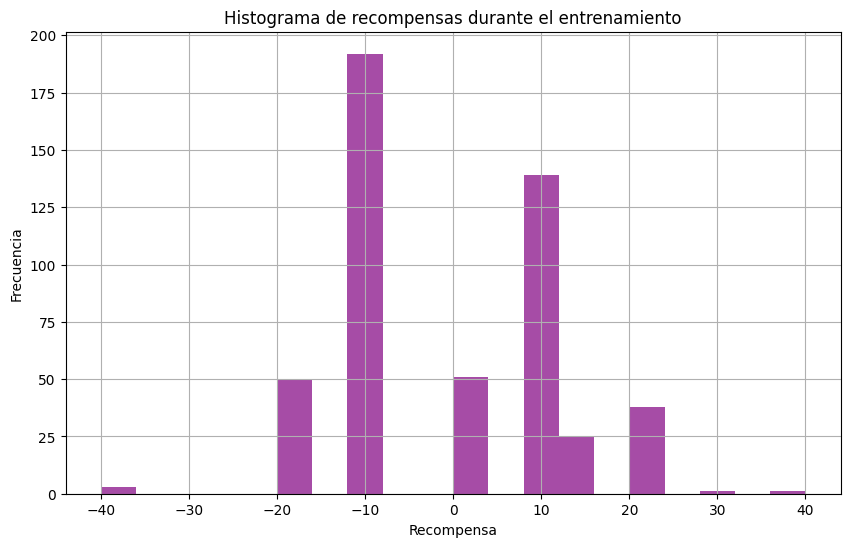

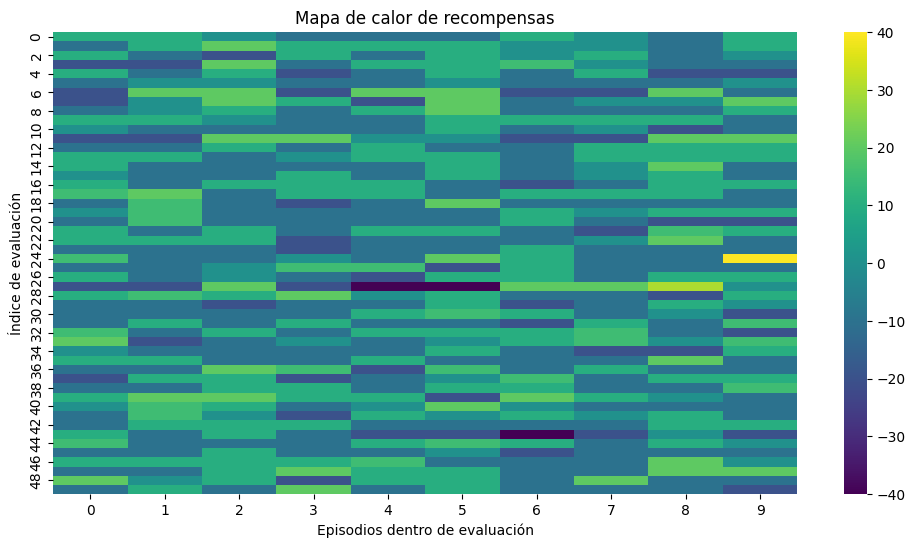

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos del archivo de evaluaciones
log_path = "./logs/evaluations.npz"
data = np.load(log_path)

# Extraer información relevante
timesteps = data["timesteps"]
mean_rewards = data["results"].mean(axis=1)
std_rewards = data["results"].std(axis=1)
max_rewards = data["results"].max(axis=1)
min_rewards = data["results"].min(axis=1)

# Graficar el desempeño del modelo con promedio, desviación estándar, máximo y mínimo
plt.figure(figsize=(12, 7))
plt.plot(timesteps, mean_rewards, label="Recompensa promedio", color="b")
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.2,
    label="Desviación estándar",
    color="b"
)
plt.plot(timesteps, max_rewards, label="Recompensa máxima", linestyle="--", color="g")
plt.plot(timesteps, min_rewards, label="Recompensa mínima", linestyle="--", color="r")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Recompensa")
plt.title("Desempeño del modelo durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

# Tasa de mejora promedio entre evaluaciones
mean_diff = np.diff(mean_rewards)
plt.figure(figsize=(10, 6))
plt.plot(timesteps[1:], mean_diff, label="Incremento promedio entre evaluaciones", color="orange")
plt.axhline(0, color="red", linestyle="--", label="Sin mejora")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Incremento promedio")
plt.title("Tasa de mejora entre evaluaciones")
plt.legend()
plt.grid()
plt.show()

# Estabilidad en las últimas evaluaciones
last_rewards = data["results"][-10:]
last_variance = np.std(mean_rewards[-10:])
print(f"Estabilidad de las últimas recompensas (desviación estándar): {last_variance:.2f}")

# Porcentaje de evaluaciones que superan un umbral de recompensa
threshold = 0.8
above_threshold = np.sum(mean_rewards > threshold) / len(mean_rewards) * 100
print(f"Porcentaje de evaluaciones con recompensa promedio > {threshold}: {above_threshold:.2f}%")

# Identificar el mejor modelo y cuándo se obtuvo
best_eval_idx = np.argmax(mean_rewards)
best_timestep = timesteps[best_eval_idx]
best_mean_reward = mean_rewards[best_eval_idx]
print(f"El mejor modelo se obtuvo en el timestep {best_timestep} con una recompensa promedio de {best_mean_reward:.2f}")

# Histograma de recompensas
all_rewards = data["results"].flatten()
plt.figure(figsize=(10, 6))
plt.hist(all_rewards, bins=20, alpha=0.7, color="purple")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.title("Histograma de recompensas durante el entrenamiento")
plt.grid()
plt.show()

# Mapa de calor de recompensas
plt.figure(figsize=(12, 6))
sns.heatmap(data["results"], cmap="viridis", cbar=True)
plt.xlabel("Episodios dentro de evaluación")
plt.ylabel("Índice de evaluación")
plt.title("Mapa de calor de recompensas")
plt.show()


In [6]:
# Subir archivo a Colab
from google.colab import files

# Subir el archivo
uploaded = files.upload()

# Verificar los archivos subidos
for filename in uploaded.keys():
    print(f"Archivo subido: {filename}")

Saving dqn_blackjack.zip to dqn_blackjack.zip
Archivo subido: dqn_blackjack.zip


In [7]:
from stable_baselines3 import DQN

# Cargar el modelo
model = DQN.load("dqn_blackjack.zip")

Se han truncado las últimas 5000 líneas del flujo de salida.
[ADJUST BET] Nueva apuesta establecida: 10

--- Episodio 99685 ---
Recompensa total en el episodio 99685: 10
[SHUFFLE] Mazo barajado, conteo reiniciado.
[DRAW CARD] Carta robada: 1
[DRAW CARD] Carta robada: 9
[DRAW CARD] Carta robada: 9
[RESET] Mano del jugador: [1, 9], Carta del dealer: 9
[ACTION] Stand
[DRAW CARD] Carta robada: 10
[DEALER] Carta 2 del dealer: 10
[DEALER] Cartas del dealer: [9, 10]
[TRUE COUNT] Remaining decks: 7.923076923076923, Running count: -2, True count: -0.1262135922330097
[ADJUST BET] Nueva apuesta establecida: 10

--- Episodio 99686 ---
Recompensa total en el episodio 99686: 10
[DRAW CARD] Carta robada: 8
[DRAW CARD] Carta robada: 1
[DRAW CARD] Carta robada: 1
[RESET] Mano del jugador: [8, 1], Carta del dealer: 1
[ACTION] Stand
[DRAW CARD] Carta robada: 7
[DEALER] Carta 2 del dealer: 7
[DEALER] Cartas del dealer: [1, 7]
[TRUE COUNT] Remaining decks: 7.846153846153846, Running count: -4, True count: 

<ipython-input-44-8ca8a7e1b03a>:107: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


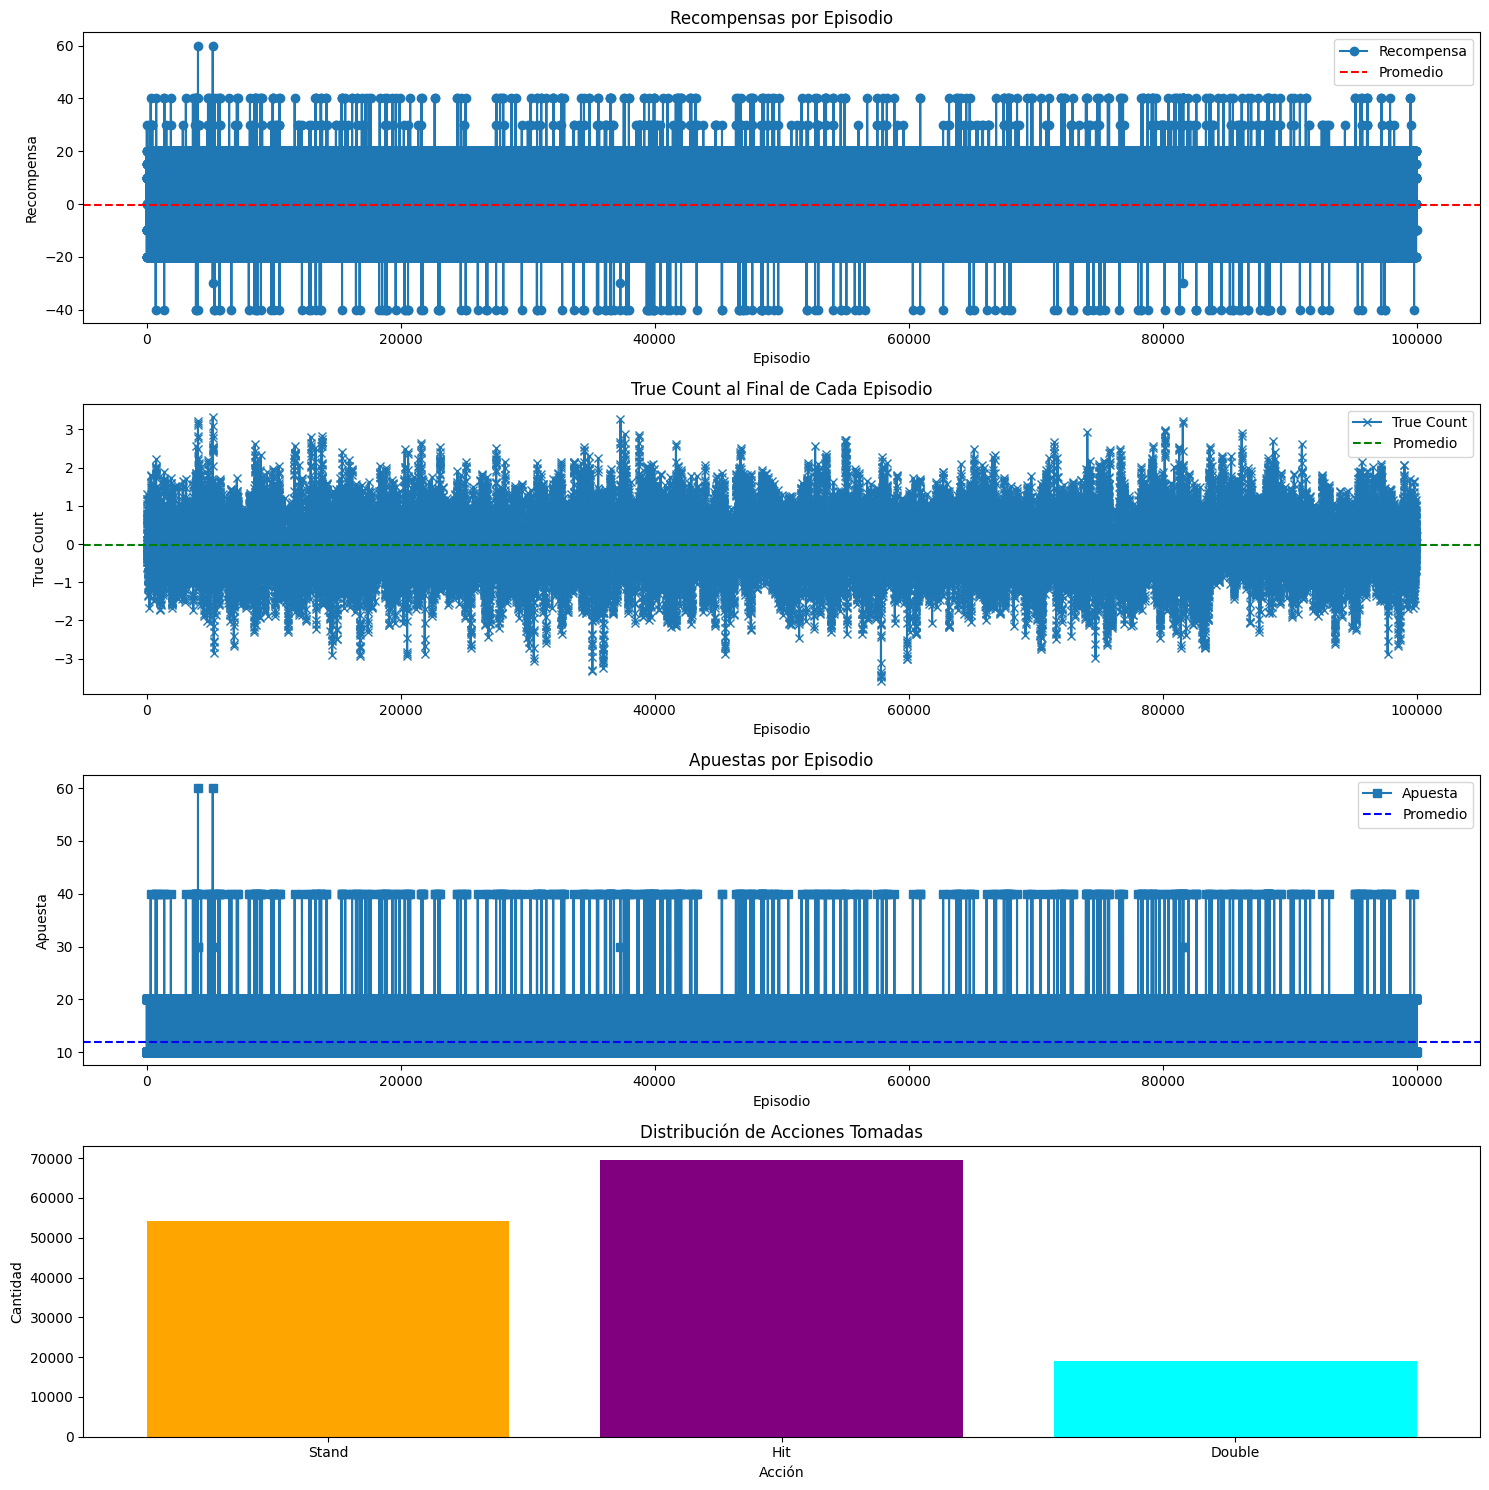

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Evaluar el modelo y registrar métricas
num_episodes = 100000
rewards = []       # Lista para recompensas por episodio
true_counts = []   # Lista para True Count al final de cada episodio
bets = []          # Lista para apuestas por episodio
actions_count = Counter({"Stand": 0, "Hit": 0, "Double": 0})  # Contador de acciones
bust_count = 0     # Contador de veces que el jugador se pasa de 21

obs, _ = env.reset()
for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Registrar la acción tomada
        if action == 0:
            actions_count["Stand"] += 1
        elif action == 1:
            actions_count["Hit"] += 1
        elif action == 2:
            actions_count["Double"] += 1

        # Verificar si el jugador se pasa de 21 usando el estado (obs)
        player_sum = obs[0]  # Asegúrate de que obs[0] representa la suma de la mano del jugador
        if player_sum > 21:
            bust_count += 1

    # Registrar métricas al final del episodio
    rewards.append(total_reward)
    true_counts.append(env.true_count)
    bets.append(env.current_bet)

    # Imprimir log del episodio
    print(f"\n--- Episodio {episode + 1} ---")
    print(f"Recompensa total en el episodio {episode + 1}: {total_reward}")
    for log_entry in env.log:
        print(log_entry)
    env.log = []  # Limpiar el registro para la próxima ronda

# Calcular victorias, derrotas y empates
wins = len([r for r in rewards if r > 0])
losses = len([r for r in rewards if r < 0])
draws = len([r for r in rewards if r == 0])

# Análisis de las métricas
print("\n--- Resumen de resultados ---")
print(f"Episodios totales: {num_episodes}")
print(f"Victorias: {wins} ({(wins / num_episodes) * 100:.2f}%)")
print(f"Derrotas: {losses} ({(losses / num_episodes) * 100:.2f}%)")
print(f"Empates: {draws} ({(draws / num_episodes) * 100:.2f}%)")
print(f"Recompensa total: {sum(rewards):.2f}")
print(f"Recompensa promedio por episodio: {np.mean(rewards):.2f}")
print("\nAcciones tomadas:")
print(f"Stand: {actions_count['Stand']}")
print(f"Hit: {actions_count['Hit']}")
print(f"Double: {actions_count['Double']}")
print(f"Veces que el jugador se pasa de 21: {bust_count}")

# Generar gráficos de métricas
plt.figure(figsize=(15, 15))

# Gráfico 1: Recompensas por episodio
plt.subplot(4, 1, 1)
plt.plot(range(1, num_episodes + 1), rewards, marker='o', linestyle='-', label="Recompensa")
plt.axhline(y=np.mean(rewards), color='r', linestyle='--', label="Promedio")
plt.title("Recompensas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()

# Gráfico 2: True Count por episodio
plt.subplot(4, 1, 2)
plt.plot(range(1, num_episodes + 1), true_counts, marker='x', linestyle='-', label="True Count")
plt.axhline(y=np.mean(true_counts), color='g', linestyle='--', label="Promedio")
plt.title("True Count al Final de Cada Episodio")
plt.xlabel("Episodio")
plt.ylabel("True Count")
plt.legend()

# Gráfico 3: Apuestas por episodio
plt.subplot(4, 1, 3)
plt.plot(range(1, num_episodes + 1), bets, marker='s', linestyle='-', label="Apuesta")
plt.axhline(y=np.mean(bets), color='b', linestyle='--', label="Promedio")
plt.title("Apuestas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Apuesta")
plt.legend()

# Gráfico 4: Distribución de acciones
plt.subplot(4, 1, 4)
actions_labels = ["Stand", "Hit", "Double"]
actions_values = [actions_count["Stand"], actions_count["Hit"], actions_count["Double"]]
plt.bar(actions_labels, actions_values, color=['orange', 'purple', 'cyan'])
plt.title("Distribución de Acciones Tomadas")
plt.xlabel("Acción")
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()